Data Exploration

/tmp/ipykernel_8337/611426759.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.resample('10T').mean()  # Ensure uniform time intervals


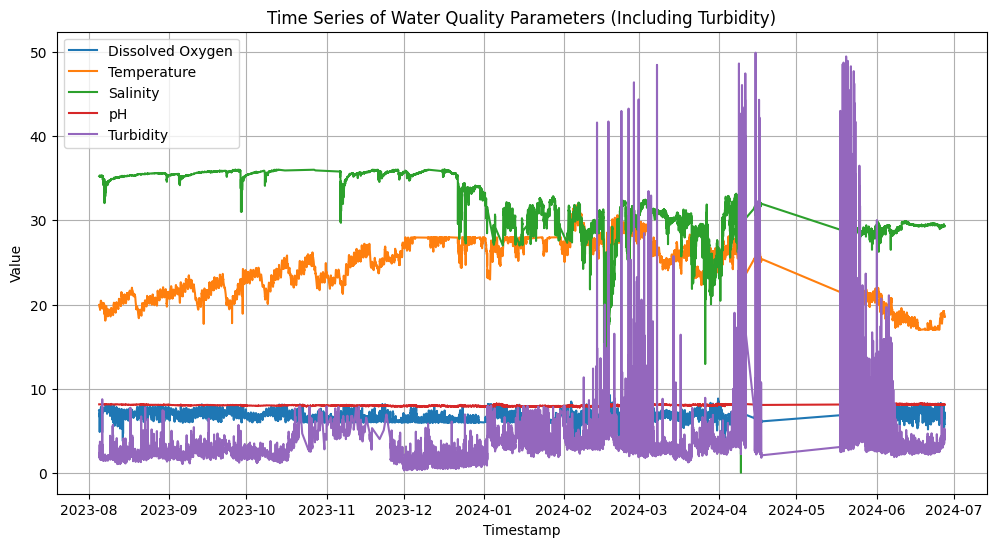

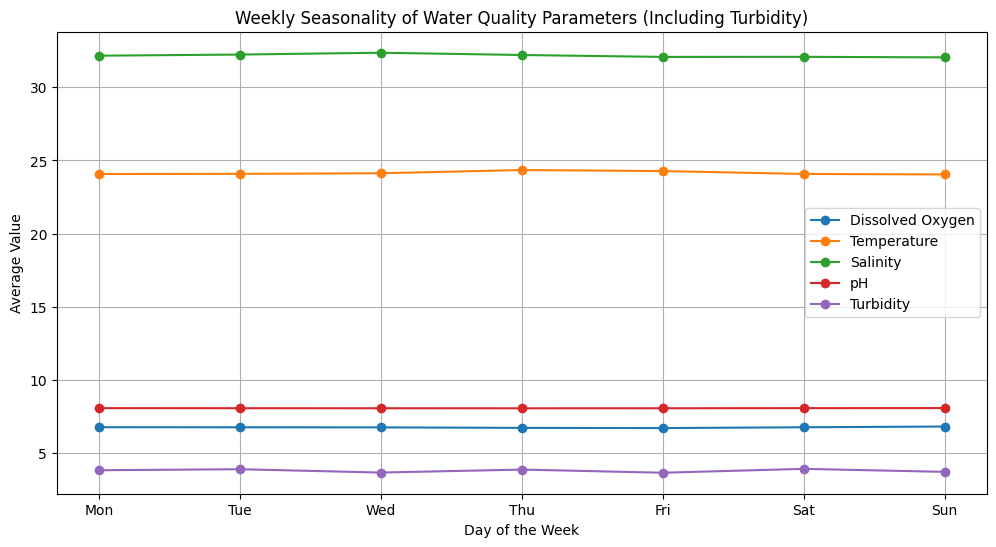

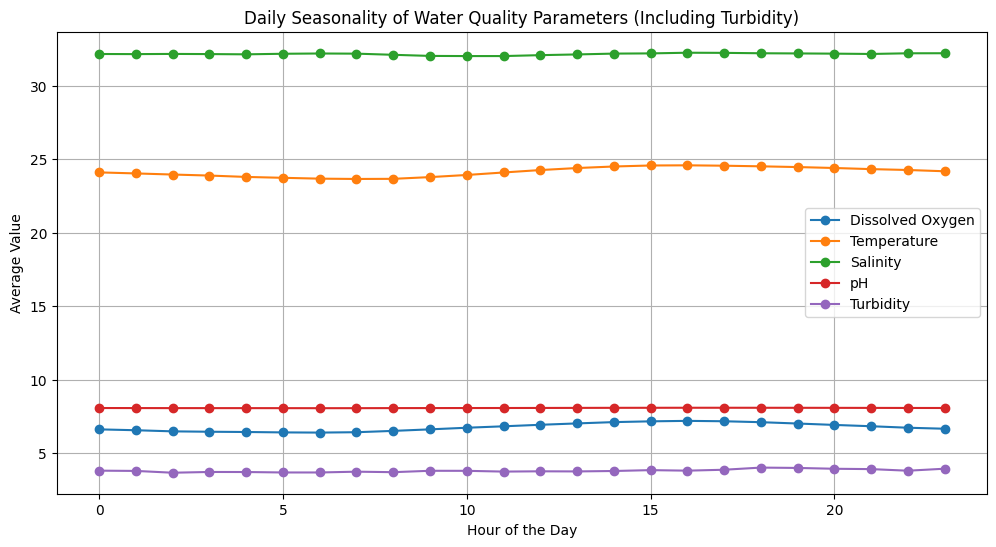

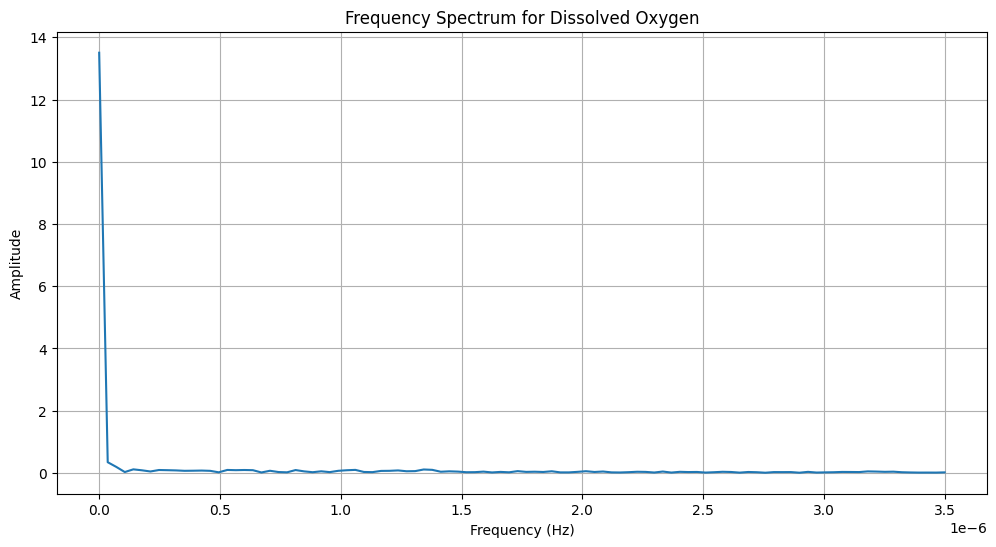

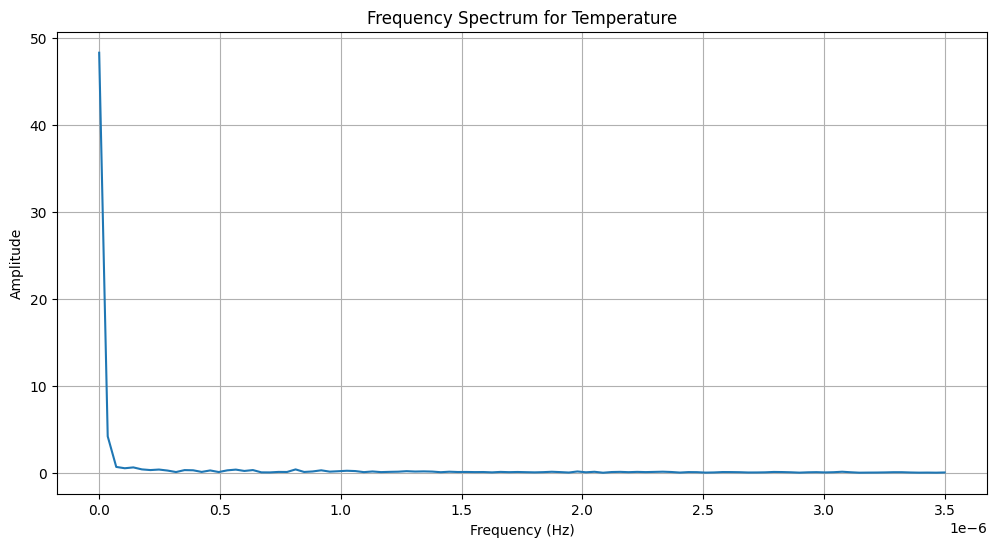

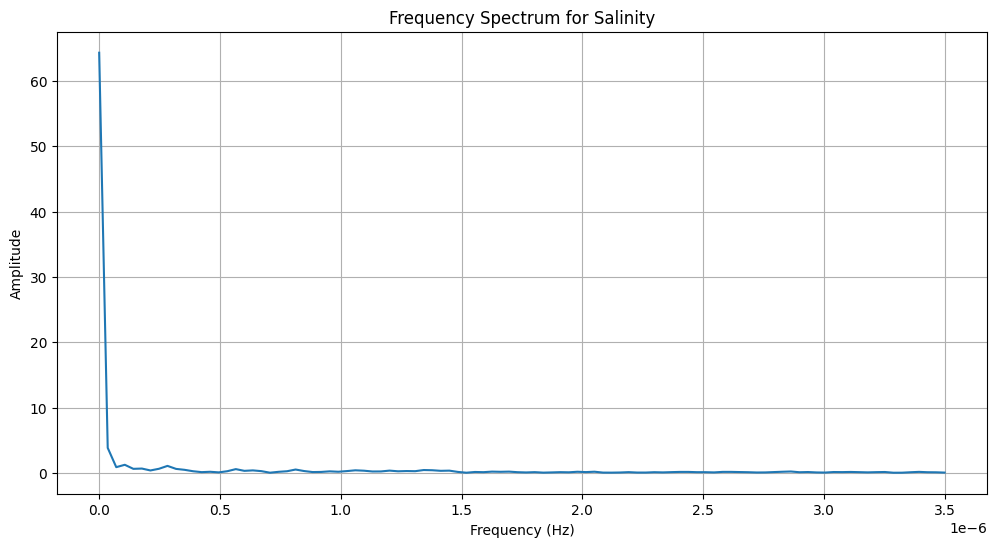

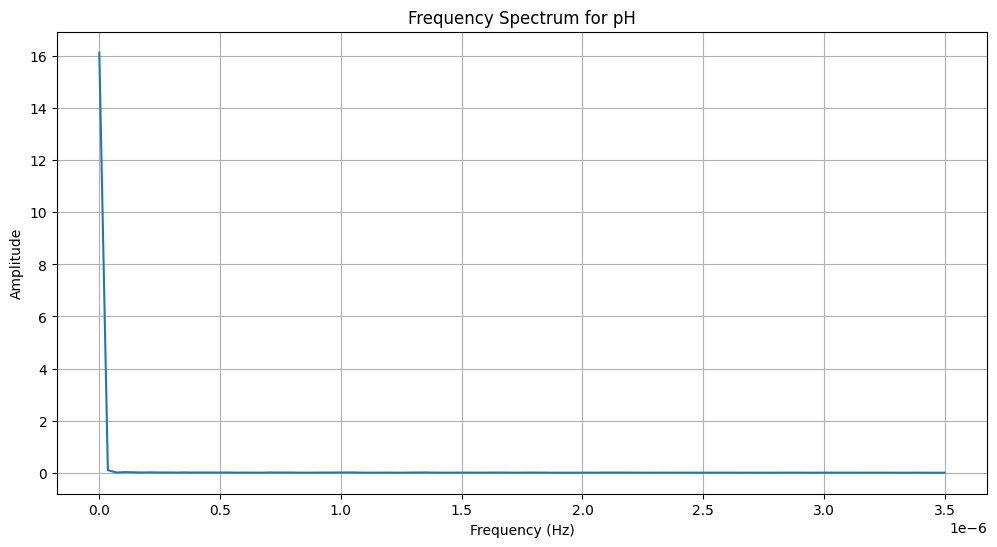

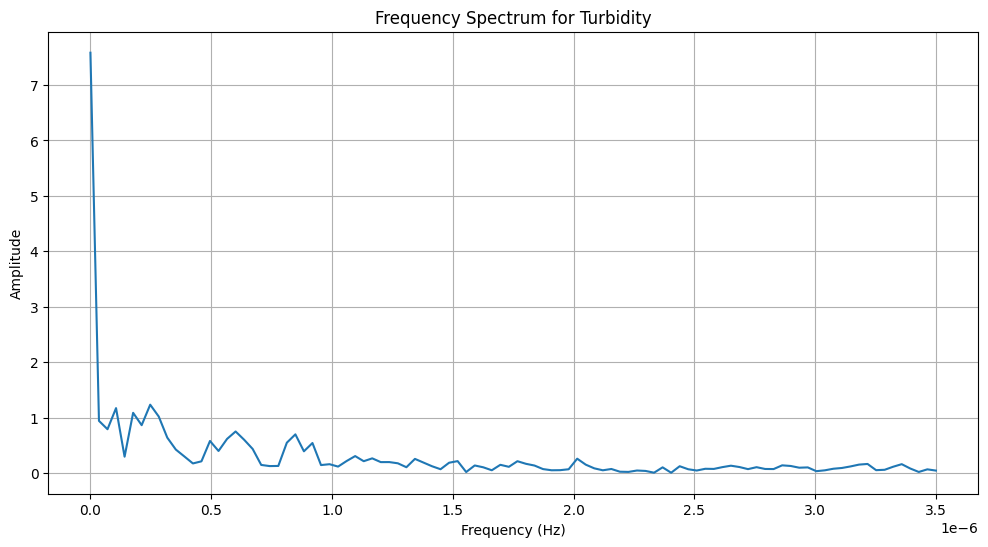

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft

# Load dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'
data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Handle irregular time steps and resample to 10-minute intervals
data.set_index('Timestamp', inplace=True)
data = data.resample('10T').mean()  # Ensure uniform time intervals
data.interpolate(method='time', inplace=True)

# Select relevant columns for seasonality analysis
target_columns = ['Dissolved Oxygen', 'Temperature', 'Salinity', 'pH', 'Turbidity']

# Visualization of raw time series
plt.figure(figsize=(12, 6))
for target in target_columns:
    plt.plot(data.index, data[target], label=target)
plt.title('Time Series of Water Quality Parameters (Including Turbidity)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Weekly seasonality: Aggregating by day of the week
data['DayOfWeek'] = data.index.dayofweek  # Monday=0, Sunday=6
weekly_seasonality = data.groupby('DayOfWeek')[target_columns].mean()

plt.figure(figsize=(12, 6))
for target in target_columns:
    plt.plot(weekly_seasonality.index, weekly_seasonality[target], marker='o', label=target)
plt.title('Weekly Seasonality of Water Quality Parameters (Including Turbidity)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Value')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.grid()
plt.show()

# Daily seasonality: Aggregating by hour of the day
data['Hour'] = data.index.hour
daily_seasonality = data.groupby('Hour')[target_columns].mean()

plt.figure(figsize=(12, 6))
for target in target_columns:
    plt.plot(daily_seasonality.index, daily_seasonality[target], marker='o', label=target)
plt.title('Daily Seasonality of Water Quality Parameters (Including Turbidity)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Value')
plt.legend()
plt.grid()
plt.show()

# Fourier Transform for identifying dominant frequencies
for target in target_columns:
    series = data[target].fillna(0).values  # Fill NaN with 0 for FFT
    N = len(series)
    T = 10 * 60  # Sampling time in seconds (10 minutes = 600 seconds)
    yf = fft(series)
    xf = np.fft.fftfreq(N, T)[:N//2]

    plt.figure(figsize=(12, 6))
    plt.plot(xf[:100], 2.0/N * np.abs(yf[:N//2])[:100])  # Only low frequencies
    plt.title(f'Frequency Spectrum for {target}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()


GPU Check

In [1]:
import torch
# --- Check Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Transformer model with GPU acclelerated hyperparameter tuning

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

# --- Dataset Preparation ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len, feature_columns, target_columns):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len
        self.feature_columns = feature_columns
        self.target_columns = target_columns

    def __len__(self):
        return len(self.data) - self.input_len - self.output_len

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.input_len, :]
        y = self.data[idx + self.input_len: idx + self.input_len + self.output_len, :]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --- Informer Components ---
class InformerEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4, dropout=0.1
            )
            for _ in range(num_layers)
        ])
        self.embedding = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x

class InformerDecoder(nn.Module):
    def __init__(self, embed_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

class Informer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, num_heads, num_layers, dropout_rate):
        super().__init__()
        self.encoder = InformerEncoder(input_dim, embed_dim, num_heads, num_layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.decoder = InformerDecoder(embed_dim, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

# --- Training Function ---
def train_model(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_len = 32  # Lookback window
    output_len = 32  # Forecast horizon

    # Load dataset
    file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'
    data = pd.read_csv(file_path, parse_dates=['Timestamp'])
    data.set_index('Timestamp', inplace=True)
    data = data.resample('10min').mean()  # Resample to 10-minute intervals
    data.interpolate(method='time', inplace=True)

    # Normalize features
    feature_columns = ['Turbidity', 'Dissolved Oxygen', 'Temperature', 'Salinity', 'pH']
    scaler = MinMaxScaler()
    data[feature_columns] = scaler.fit_transform(data[feature_columns])

    # Prepare dataset
    dataset = data[feature_columns].values
    train_size = int(0.8 * len(dataset))
    train_data = dataset[:train_size]
    test_data = dataset[train_size:]

    train_dataset = TimeSeriesDataset(train_data, input_len, output_len, feature_columns, feature_columns)
    test_dataset = TimeSeriesDataset(test_data, input_len, output_len, feature_columns, feature_columns)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    # Model, Loss, and Optimizer
    model = Informer(
        input_dim=len(feature_columns),
        output_dim=len(feature_columns),
        embed_dim=config["embed_dim"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        dropout_rate=config["dropout_rate"],
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    for epoch in range(10):  # Keep epochs small for hyperparameter tuning
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(test_loader)

        # Report metrics to Ray Tune
        session.report({"train_loss": train_loss, "val_loss": val_loss})

# --- Ray Tune Configuration ---
tune_config = {
    "batch_size": tune.choice([32, 64, 128]),
    "embed_dim": tune.choice([32, 64, 128, 256]),
    "num_heads": tune.choice([2, 4, 8, 16]),
    "num_layers": tune.choice([1, 2, 3, 4]),
    "dropout_rate": tune.uniform(0.1, 0.7),
    "learning_rate": tune.loguniform(1e-5, 1e-2),
}

# Scheduler
scheduler = ASHAScheduler(metric="val_loss", mode="min", max_t=50, grace_period=5)


# Wrap train_model with resources
trainable_with_resources = tune.with_resources(
    train_model,
    {"cpu": 2, "gpu": 1}  # Allocates 1 GPU per trial
)

# Run Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=tune_config,
    tune_config=tune.TuneConfig(
        num_samples=20,  # Reduce for testing
        scheduler=scheduler
    ),
)

results = tuner.fit()

# Get Best Hyperparameters
best_result = results.get_best_result(metric="val_loss", mode="min")
print("Best hyperparameters:", best_result.config)


2024-12-02 12:45:18,129	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/duncan/ray_results/train_model_2024-12-02_12-32-40' in 0.0124s.
2024-12-02 12:45:18,137	INFO tune.py:1041 -- Total run time: 754.95 seconds (754.91 seconds for the tuning loop).


Best hyperparameters: {'batch_size': 32, 'embed_dim': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.33872151893039154, 'learning_rate': 2.249676031902304e-05}


Epoch 1, Train Loss: 0.0498, Validation Loss: 0.0054
Epoch 2, Train Loss: 0.0101, Validation Loss: 0.0053
Epoch 3, Train Loss: 0.0079, Validation Loss: 0.0046
Epoch 4, Train Loss: 0.0066, Validation Loss: 0.0042
Epoch 5, Train Loss: 0.0057, Validation Loss: 0.0047
Epoch 6, Train Loss: 0.0050, Validation Loss: 0.0041
Epoch 7, Train Loss: 0.0046, Validation Loss: 0.0041
Epoch 8, Train Loss: 0.0043, Validation Loss: 0.0045
Epoch 9, Train Loss: 0.0041, Validation Loss: 0.0044
Early stopping at epoch 9, best validation loss: 0.0042


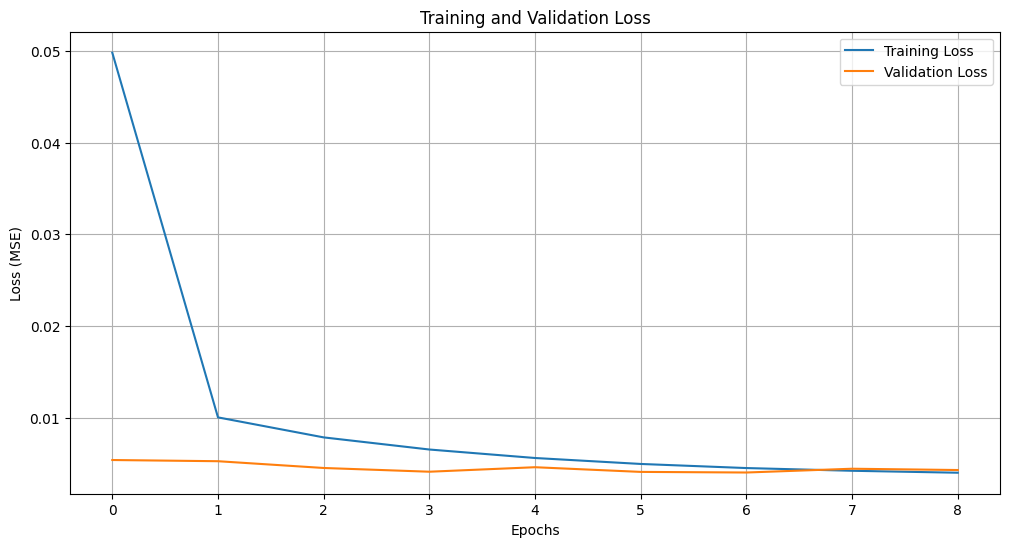

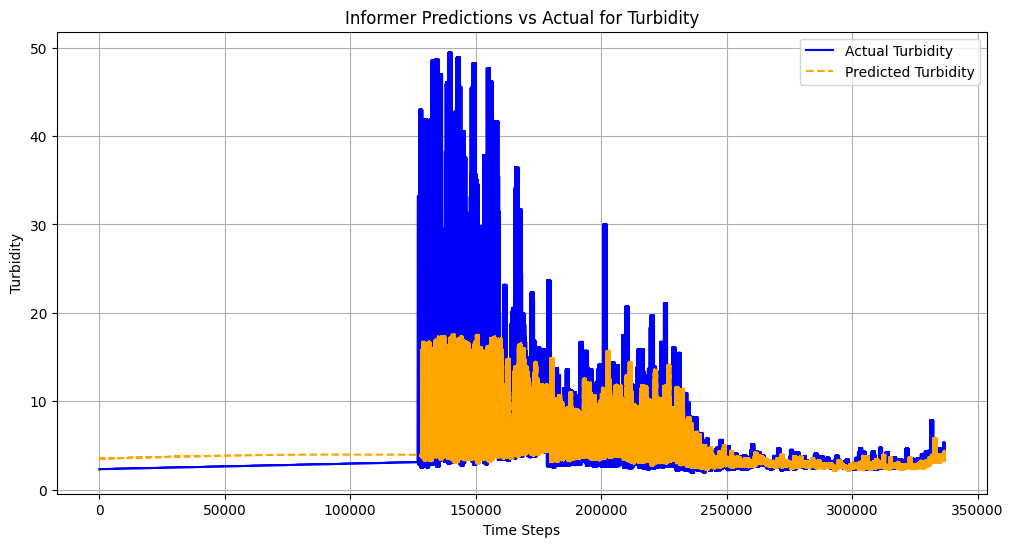

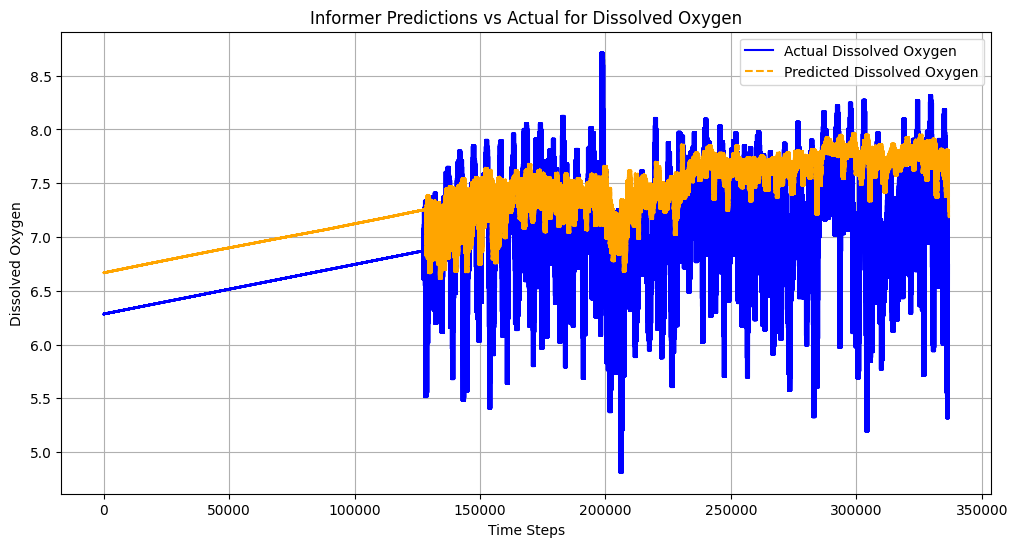

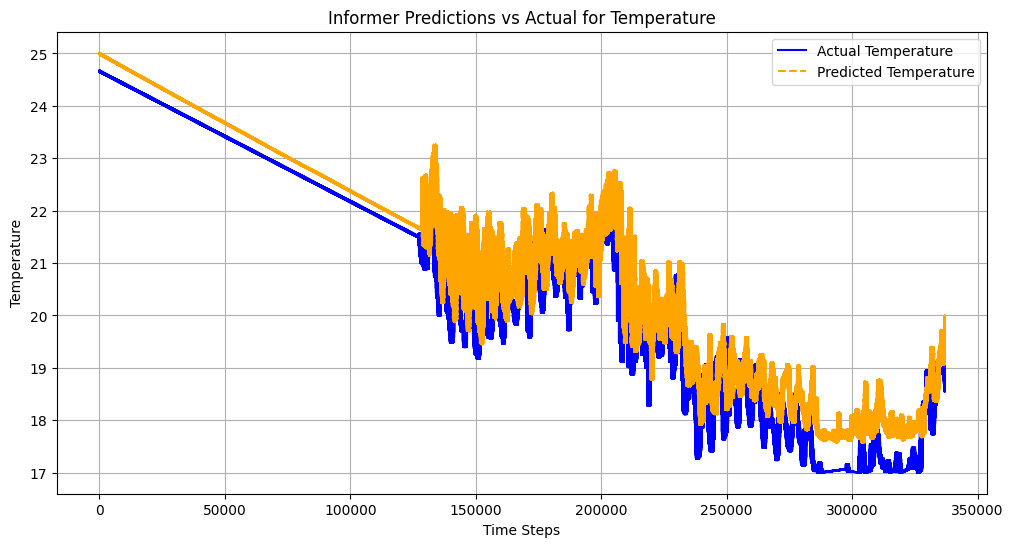

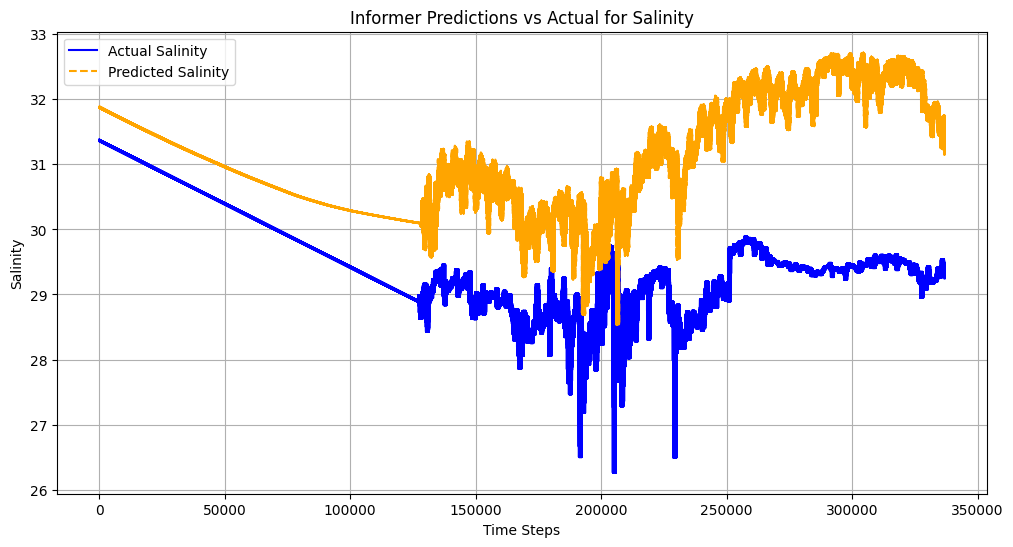

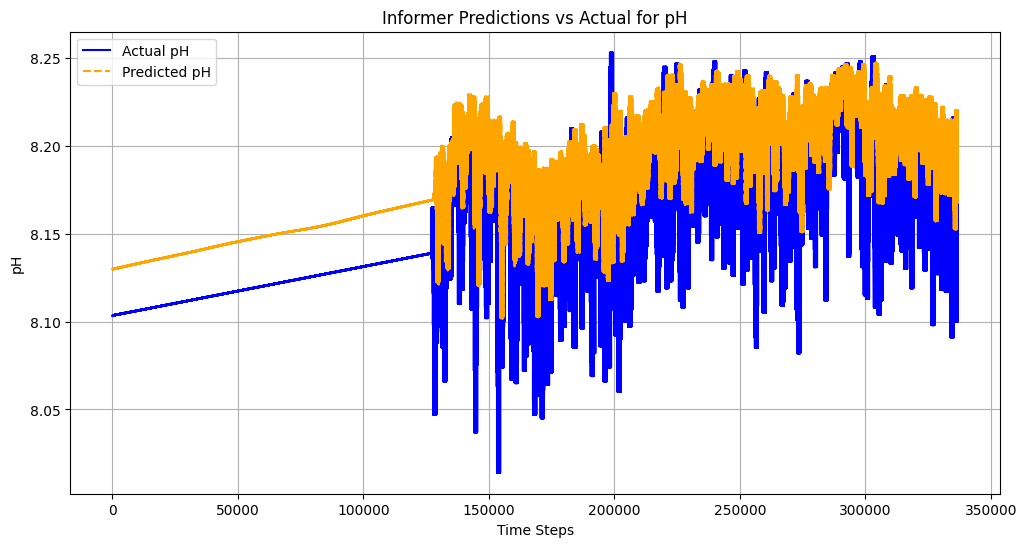

Turbidity - MSE: 18.0954, MAE: 1.9224, R²: 0.4027
Dissolved Oxygen - MSE: 0.3188, MAE: 0.4557, R²: -0.3385
Temperature - MSE: 0.4258, MAE: 0.5038, R²: 0.9212
Salinity - MSE: 3.4843, MAE: 1.6255, R²: -5.0548
pH - MSE: 0.0014, MAE: 0.0307, R²: 0.0172


In [8]:
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Final Model Training and Evaluation with Early Stopping ---
def train_final_model(best_hyperparams, train_dataset, test_dataset, feature_columns, scaler):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(train_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_hyperparams["batch_size"], shuffle=False)

    # Initialize the model with best hyperparameters
    model = Informer(
        input_dim=len(feature_columns),
        output_dim=len(feature_columns),
        embed_dim=best_hyperparams["embed_dim"],
        num_heads=best_hyperparams["num_heads"],
        num_layers=best_hyperparams["num_layers"],
        dropout_rate=best_hyperparams["dropout_rate"],
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_hyperparams["learning_rate"])

    # Early stopping parameters
    patience = 5
    min_delta = 1e-4
    best_val_loss = float('inf')
    patience_counter = 0

    # Train the model
    train_loss_history, val_loss_history = [], []
    for epoch in range(50):  # Maximum epochs
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}, best validation loss: {best_val_loss:.4f}")
                break

    # --- Visualization: Loss Curves ---
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # --- Evaluation ---
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Rescale predictions and actuals
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, len(feature_columns)))
    actuals_rescaled = scaler.inverse_transform(actuals.reshape(-1, len(feature_columns)))

    # --- Visualization: Predictions vs Actuals ---
    for i, col in enumerate(feature_columns):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals_rescaled[:, i], label=f'Actual {col}', color='blue')
        plt.plot(predictions_rescaled[:, i], label=f'Predicted {col}', color='orange', linestyle='--')
        plt.legend()
        plt.title(f'Informer Predictions vs Actual for {col}')
        plt.xlabel('Time Steps')
        plt.ylabel(col)
        plt.grid()
        plt.show()

    # --- Accuracy Metrics ---
    metrics = {}
    for i, col in enumerate(feature_columns):
        mse = mean_squared_error(actuals_rescaled[:, i], predictions_rescaled[:, i])
        mae = mean_absolute_error(actuals_rescaled[:, i], predictions_rescaled[:, i])
        r2 = r2_score(actuals_rescaled[:, i], predictions_rescaled[:, i])
        metrics[col] = {"MSE": mse, "MAE": mae, "R²": r2}

    for col, metric in metrics.items():
        print(f"{col} - MSE: {metric['MSE']:.4f}, MAE: {metric['MAE']:.4f}, R²: {metric['R²']:.4f}")


# --- Use Best Hyperparameters ---
# Prepare datasets again (ensures no overlap with tuning process)
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'
data = pd.read_csv(file_path, parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)
data = data.resample('10min').mean()
data.interpolate(method='time', inplace=True)

feature_columns = ['Turbidity', 'Dissolved Oxygen', 'Temperature', 'Salinity', 'pH']
scaler = MinMaxScaler()
data[feature_columns] = scaler.fit_transform(data[feature_columns])

dataset = data[feature_columns].values
train_size = int(0.8 * len(dataset))
train_data = dataset[:train_size]
test_data = dataset[train_size:]

train_dataset = TimeSeriesDataset(train_data, 36, 36, feature_columns, feature_columns)
test_dataset = TimeSeriesDataset(test_data, 36, 36, feature_columns, feature_columns)

# Train final model using best hyperparameters
train_final_model(best_result.config, train_dataset, test_dataset, feature_columns, scaler)


GPU Check

In [ ]:
import tensorflow as tf

# Check if TensorFlow can access GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is connected to the GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu.name}")
else:
    print("TensorFlow is not connected to any GPU. Check your GPU setup.")

/tmp/ipykernel_4260/592451080.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_4260/592451080.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Training data shape: (24684, 1, 33)
Validation data shape: (3085, 1, 33)
Test data shape: (3086, 1, 33)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_input          │ (None, 1, 33)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ (None, 1, 128)    │     82,944 │ time_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │    263,808 │ encoder_lstm[0][… │
│ (MultiHeadAttentio… │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attention  │ (None, 1, 128)    │          0 │ encoder_lstm[0][… │
│ (Add)               │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 64)        │     49,408 │ residual_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 180)       │     11,700 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_output      │ (None, 36, 5)     │          0 │ output_layer[0][… │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 412,020 (1.57 MB)

 Trainable params: 412,020 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/home/duncan/miniconda3/envs/tflastchance/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0972 - mae: 0.2288 - mse: 0.0972 - val_loss: 0.0384 - val_mae: 0.1358 - val_mse: 0.0384
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - mae: 0.0940 - mse: 0.0161 - val_loss: 0.0340 - val_mae: 0.1275 - val_mse: 0.0340
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - mae: 0.0850 - mse: 0.0135 - val_loss: 0.0258 - val_mae: 0.1084 - val_mse: 0.0258
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0117 - mae: 0.0785 - mse: 0.0117 - val_loss: 0.0261 - val_mae: 0.1151 - val_mse: 0.0261
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0105 - mae: 0.0737 - mse: 0.0105 - val_loss: 0.0249 - val_mae: 0.1147 - val_mse: 0.0249
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0096 - mae: 0.0701 - mse: 0.0096 - val_loss: 0.0279 - val_mae: 0.1207 - val_mse: 0.0279
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - mae: 0.0668 - mse: 0.0089 - val_loss: 0.02

/home/duncan/miniconda3/envs/tflastchance/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dissolved Oxygen - MSE: 0.0313, MAE: 0.1378, R²: 0.0201
Temperature - MSE: 0.0368, MAE: 0.1859, R²: -8.8725
Salinity - MSE: 0.0473, MAE: 0.2140, R²: -87.9729
pH - MSE: 0.0134, MAE: 0.0961, R²: -0.7531
Turbidity - MSE: 0.0028, MAE: 0.0381, R²: -0.2151


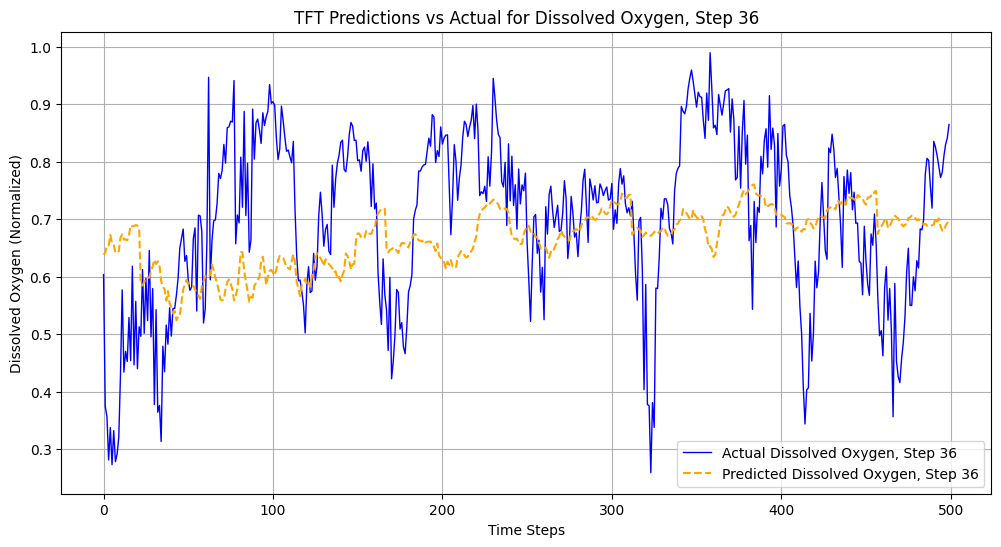

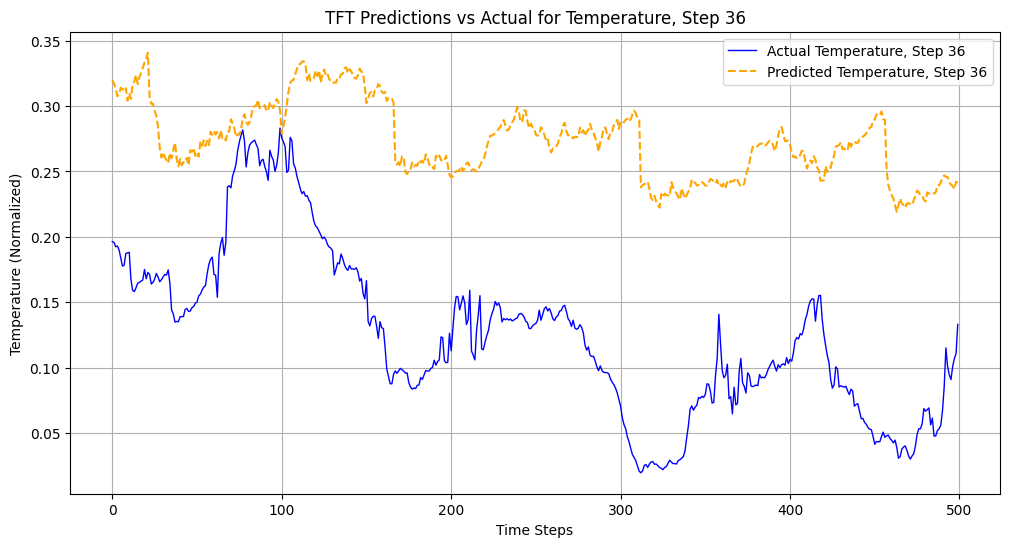

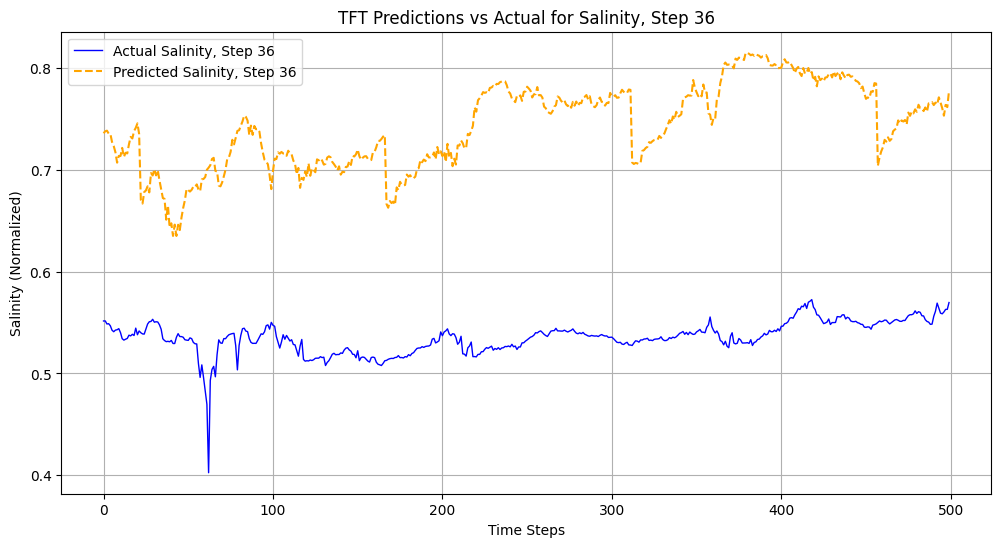

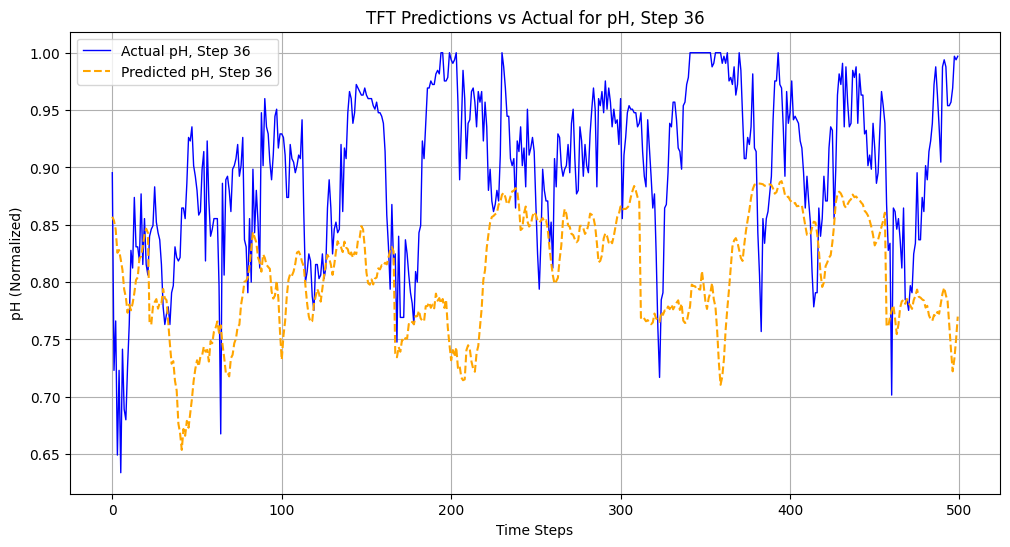

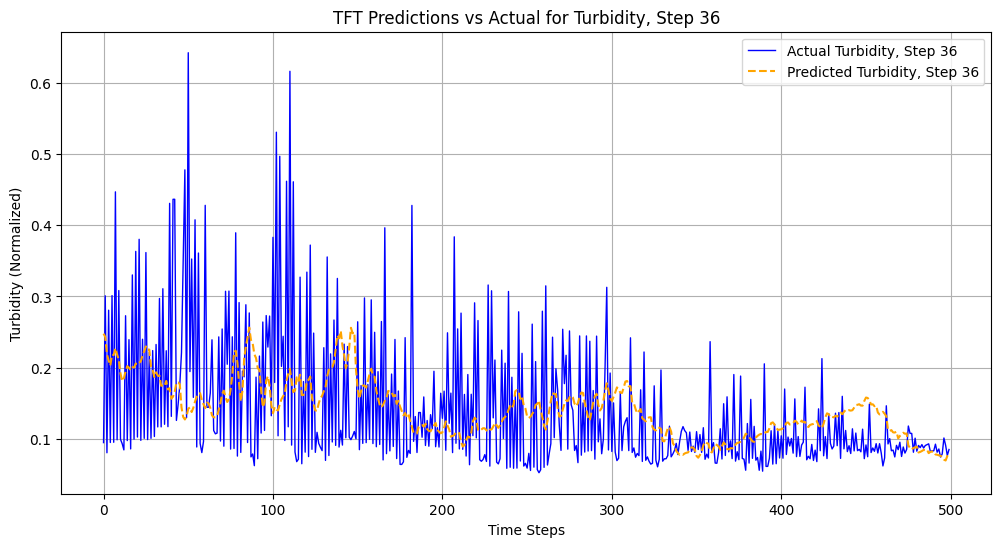

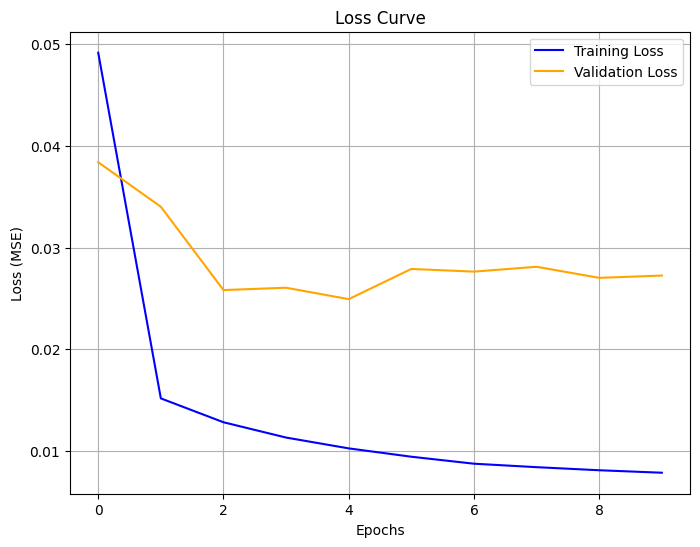

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Data Preprocessing ---
# Load the dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'  
data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Step 1: Handle Missing Values
data.fillna(method='ffill', inplace=True)
data.interpolate(method='linear', inplace=True)

# Step 2: Select Relevant Features
target_columns = ['Dissolved Oxygen', 'Temperature', 'Salinity', 'pH', 'Turbidity']
predictors = target_columns + ['Chlorophyll']  # Add Chlorophyll as a predictor
data = data[['Timestamp'] + predictors]

# Step 3: Analyze and Remove Outliers for Targets
for target in target_columns:
    lower_bound = data[target].quantile(0.01)
    upper_bound = data[target].quantile(0.99)
    data[target] = data[target].clip(lower=lower_bound, upper=upper_bound)

# Step 4: Add Moving Averages for Predictors
for feature in predictors:
    data[f'{feature}_MA3'] = data[feature].rolling(window=3).mean()
    data[f'{feature}_MA5'] = data[feature].rolling(window=5).mean()

# Fill NaN values introduced by moving averages
data.fillna(method='bfill', inplace=True)

# Step 5: Add Time-Based Features
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek

# Step 6: Add Lagged Features for Predictors
for feature in predictors:
    for lag in range(1, 4):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Step 7: Normalize Features
scaler = MinMaxScaler()
scaled_columns = predictors + [f'{feature}_lag{lag}' for feature in predictors for lag in range(1, 4)] + \
                 [f'{feature}_MA3' for feature in predictors] + [f'{feature}_MA5' for feature in predictors] + target_columns
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Step 8: Split Features and Targets for Multi-Horizon Forecast
X = data.drop(columns=['Timestamp'] + target_columns).values
y = np.array([data[target_columns].iloc[i:i + 36].values for i in range(len(data) - 36)])  # Multi-step, multi-variable targets

# Trim X to match the target shape
X = X[:len(y)]

# Split Data into Training, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Reshape for models that expect sequential input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to build the TFT model
def build_tft_model(input_shape, forecast_steps, num_targets):
    # Input for time-varying features
    time_input = tf.keras.Input(shape=(input_shape[0], input_shape[1]), name="time_input")

    # Encoder (LSTM)
    encoded = layers.LSTM(128, return_sequences=True, name="encoder_lstm")(time_input)

    # Temporal Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=128, name="attention")(encoded, encoded)
    attention_out = layers.Add(name="residual_attention")([encoded, attention])

    # Decoder (LSTM)
    decoded = layers.LSTM(64, return_sequences=False, name="decoder_lstm")(attention_out)

    # Fully connected layers for prediction
    dense_out = layers.Dense(64, activation="relu", name="dense_1")(decoded)
    dense_out = layers.Dropout(0.3, name="dropout")(dense_out)

    # Output layer (multi-step prediction for multiple targets)
    outputs = layers.Dense(forecast_steps * num_targets, name="output_layer")(dense_out)
    outputs = layers.Reshape((forecast_steps, num_targets), name="reshape_output")(outputs)

    # Define the model
    model = Model(inputs=time_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", "mse"])
    return model

# Define the forecast horizon (e.g., 36 steps for 6 hours if 10 minutes per step)
forecast_steps = 36
num_targets = y_train.shape[2]  # Number of target variables

# Build the TFT model
input_shape = (X_train.shape[1], X_train.shape[2])  # Time steps and features
tft_model = build_tft_model(input_shape, forecast_steps, num_targets)

# Print the model summary
tft_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the TFT model
history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_mae, test_mse = tft_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

# Predict and evaluate
predictions = tft_model.predict(X_test)

# --- Accuracy Metrics ---
metrics = {}
for target_idx, target_name in enumerate(target_columns):
    mse = mean_squared_error(y_test[:, :, target_idx], predictions[:, :, target_idx])
    mae = mean_absolute_error(y_test[:, :, target_idx], predictions[:, :, target_idx])
    r2 = r2_score(y_test[:, :, target_idx], predictions[:, :, target_idx])
    metrics[target_name] = {"MSE": mse, "MAE": mae, "R²": r2}

# Print metrics for all target variables
for target, metric in metrics.items():
    print(f"{target} - MSE: {metric['MSE']:.4f}, MAE: {metric['MAE']:.4f}, R²: {metric['R²']:.4f}")

# Subset data for visualization
subset = 500  # Display the first 500 samples
y_test_subset = y_test[:subset]
predictions_subset = predictions[:subset]

# Visualization for Step 36 (6-hour horizon) for all targets
step_to_analyze = 35  # Step 36 (index 35)
for target_idx, target_name in enumerate(target_columns):
    plt.figure(figsize=(12, 6))
    plt.plot(
        range(len(y_test_subset)),
        y_test_subset[:, step_to_analyze, target_idx],
        label=f'Actual {target_name}, Step {step_to_analyze + 1}',
        color='blue',
        linewidth=1
    )
    plt.plot(
        range(len(predictions_subset)),
        predictions_subset[:, step_to_analyze, target_idx],
        label=f'Predicted {target_name}, Step {step_to_analyze + 1}',
        color='orange',
        linestyle='--'
    )
    plt.legend()
    plt.title(f'TFT Predictions vs Actual for {target_name}, Step {step_to_analyze + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel(f'{target_name} (Normalized)')
    plt.grid()
    plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()


LSTM Model (single variable)

/tmp/ipykernel_4260/410426600.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.resample('10T').mean()  # Resample to 10-minute intervals
/tmp/ipykernel_4260/410426600.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Fill missing values introduced by moving averages


Training data shape: (37716, 1, 18)
Validation data shape: (4714, 1, 18)
Testing data shape: (4715, 1, 18)


/home/duncan/miniconda3/envs/tflastchance/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,737 (487.25 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0855 - mae: 0.0855 - mse: 0.0205 - val_loss: 0.0108 - val_mae: 0.0108 - val_mse: 2.6257e-04
Epoch 2/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0290 - mae: 0.0290 - mse: 0.0015 - val_loss: 0.0116 - val_mae: 0.0116 - val_mse: 2.7298e-04
Epoch 3/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0197 - mae: 0.0197 - mse: 7.0466e-04 - val_loss: 0.0062 - val_mae: 0.0062 - val_mse: 1.7804e-04
Epoch 4/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0153 - mae: 0.0153 - mse: 4.6516e-04 - val_loss: 0.0065 - val_mae: 0.0065 - val_mse: 1.6236e-04
Epoch 5/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0140 - mae: 0.0140 - mse: 3.8524e-04 - val_loss: 0.0105 - val_mae: 0.0105 - val_mse: 2.1457e-04
Epoch 6/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0137 - mae: 0.0137 - mse: 3.7714e-04 - val_loss: 0.0089 - val_mae: 0.0089 - val_mse: 1.7148e-04
Epoch 7/50
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms

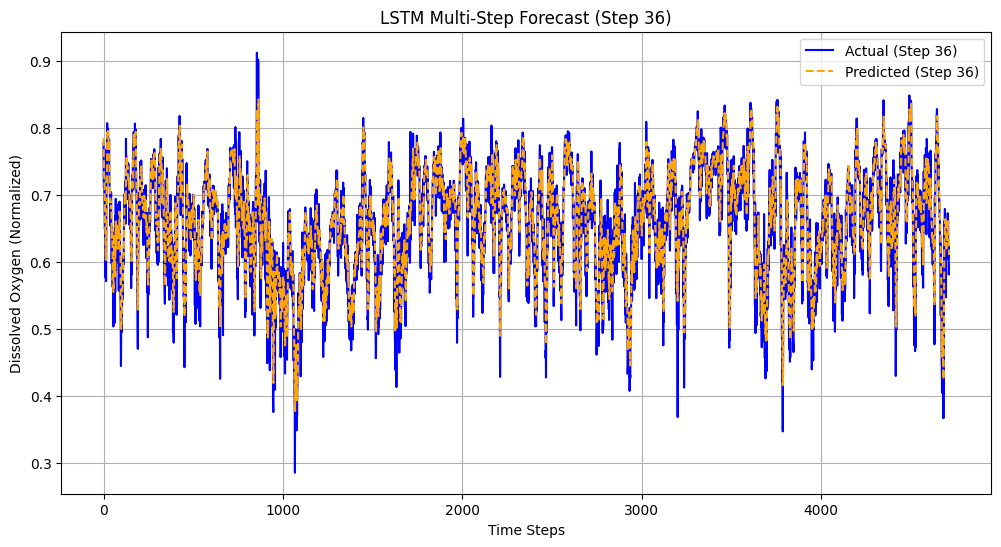

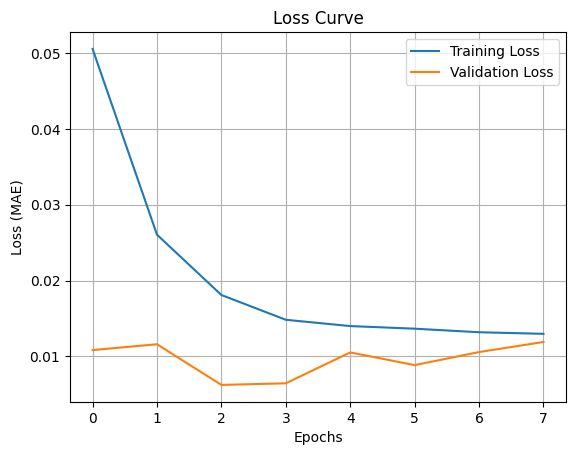

Step 36 - MSE: 0.0008, MAE: 0.0212, R²: 0.8847


In [ ]:
# --- Libraries ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Data Preprocessing ---
# Load dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'
data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Step 1: Handle Irregular Time Steps
data.set_index('Timestamp', inplace=True)
data = data.resample('10T').mean()  # Resample to 10-minute intervals
data.interpolate(method='time', inplace=True)

# Step 2: Remove Duplicate Timestamps
data = data.reset_index()
data = data.drop_duplicates(subset='Timestamp')

# Step 3: Select Relevant Features
target = 'Dissolved Oxygen'
predictors = ['Temperature', 'Salinity', 'pH', 'Turbidity']
data = data[['Timestamp'] + predictors + [target]]

# Step 4: Add Moving Averages for Target Variable
data['Dissolved Oxygen_MA3'] = data[target].rolling(window=3).mean()
data['Dissolved Oxygen_MA5'] = data[target].rolling(window=5).mean()
data.fillna(method='bfill', inplace=True)  # Fill missing values introduced by moving averages

# Step 5: Add Lagged Features for Predictors
for feature in predictors:
    for lag in range(1, 4):  # Adding 3 lagged features for each predictor
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)
data.dropna(inplace=True)  # Drop rows with NaN values introduced by lagging

# Step 6: Normalize Features
scaler = MinMaxScaler()
scaled_columns = predictors + [f'{feature}_lag{lag}' for feature in predictors for lag in range(1, 4)] + \
                 [target, 'Dissolved Oxygen_MA3', 'Dissolved Oxygen_MA5']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Step 7: Prepare Features and Multi-Step Target
horizon = 36  # Forecast horizon (6 hours)
X = data.drop(columns=['Timestamp', target]).values
y = np.array([data[target].iloc[i:i + horizon].values for i in range(len(data) - horizon)])

# Trim X to match y
X = X[:len(y)]

# Step 8: Split Data into Training, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Reshape X for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- LSTM Model Definition ---
def build_lstm_model(input_shape, horizon):
    model = Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape, name="lstm_1"),
        layers.Dropout(0.3, name="dropout_1"),
        layers.LSTM(64, return_sequences=False, name="lstm_2"),
        layers.Dropout(0.3, name="dropout_2"),
        layers.Dense(horizon, activation="linear", name="output_layer")  # Predict multiple timesteps
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mae", metrics=["mse", "mae"])
    return model

# Build and compile the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # [timesteps, features]
model = build_lstm_model(input_shape, horizon)

# Print model summary
model.summary()

# --- Model Training ---
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# --- Model Evaluation ---
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MAE): {test_loss}, Test MSE: {test_mse}, Test MAE: {test_mae}")

# --- Predictions ---
predictions = model.predict(X_test)

# --- Visualization ---
# Plot predictions vs actual values for step 36 (6-hour horizon)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test[:, -1], label='Actual (Step 36)', color='blue')
plt.plot(range(len(predictions)), predictions[:, -1], label='Predicted (Step 36)', color='orange', linestyle='--')
plt.legend()
plt.title('LSTM Multi-Step Forecast (Step 36)')
plt.xlabel('Time Steps')
plt.ylabel('Dissolved Oxygen (Normalized)')
plt.grid()
plt.show()

# --- Training and Validation Loss Curve ---
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid()
plt.show()

# --- Accuracy Metrics ---
mse = mean_squared_error(y_test[:, -1], predictions[:, -1])  # Compare step 36
mae = mean_absolute_error(y_test[:, -1], predictions[:, -1])
r2 = r2_score(y_test[:, -1], predictions[:, -1])

print(f"Step 36 - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


LSTM Model (multi variable)

/tmp/ipykernel_4260/1475635112.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.resample('10T').mean()  # Resample to 10-minute intervals
/tmp/ipykernel_4260/1475635112.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Fill missing values introduced by moving averages


Training data shape: (37688, 1, 25)
Validation data shape: (4711, 1, 25)
Testing data shape: (4711, 1, 25)


/home/duncan/miniconda3/envs/tflastchance/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 180)            │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 36, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,956 (546.70 KB)

 Trainable params: 139,956 (546.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0590 - mae: 0.1551 - mse: 0.0590 - val_loss: 0.0088 - val_mae: 0.0591 - val_mse: 0.0088
Epoch 2/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0074 - mae: 0.0640 - mse: 0.0074 - val_loss: 0.0063 - val_mae: 0.0485 - val_mse: 0.0063
Epoch 3/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0051 - mae: 0.0527 - mse: 0.0051 - val_loss: 0.0056 - val_mae: 0.0491 - val_mse: 0.0056
Epoch 4/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0036 - mae: 0.0443 - mse: 0.0036 - val_loss: 0.0039 - val_mae: 0.0317 - val_mse: 0.0039
Epoch 5/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0026 - mae: 0.0364 - mse: 0.0026 - val_loss: 0.0038 - val_mae: 0.0321 - val_mse: 0.0038
Epoch 6/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0021 - mae: 0.0315 - mse: 0.0021 - val_loss: 0.0032 - val_mae: 0.0242 - val_mse: 0.0032
Epoch 7/50
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0020 - mae: 0.0295 - mse

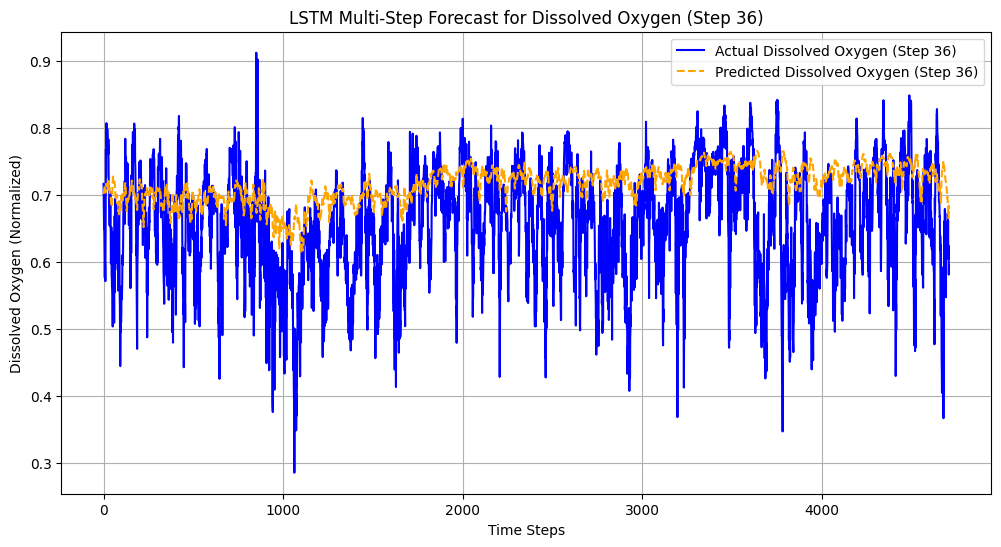

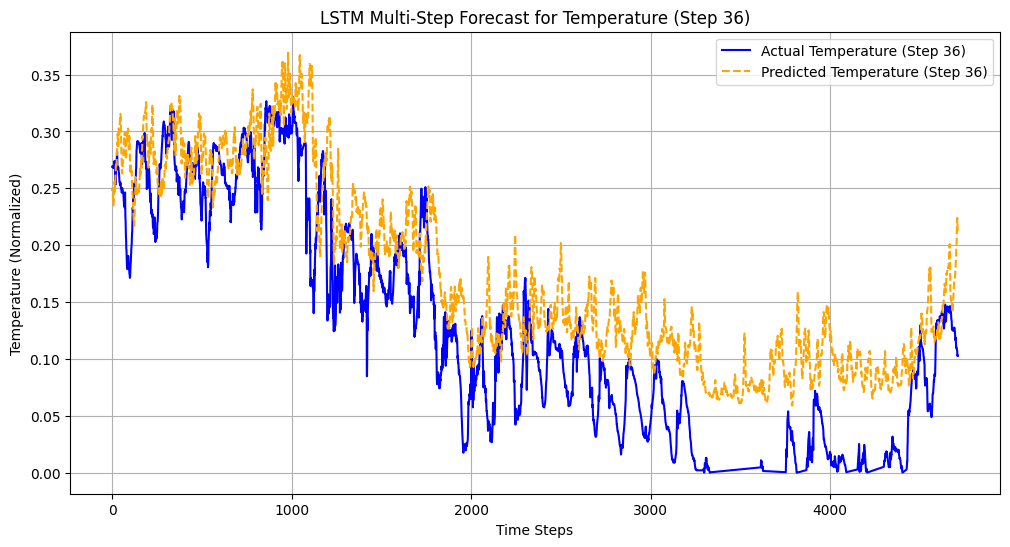

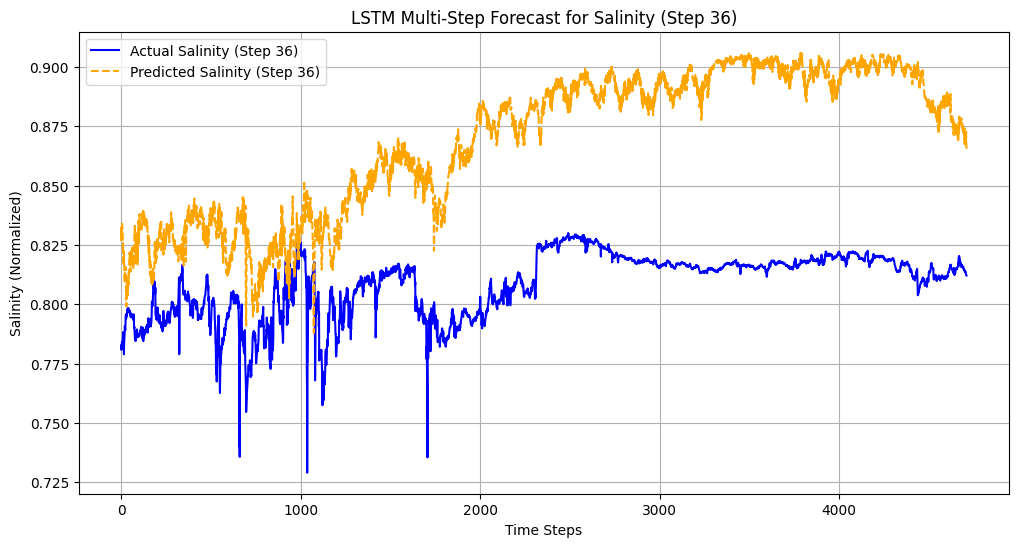

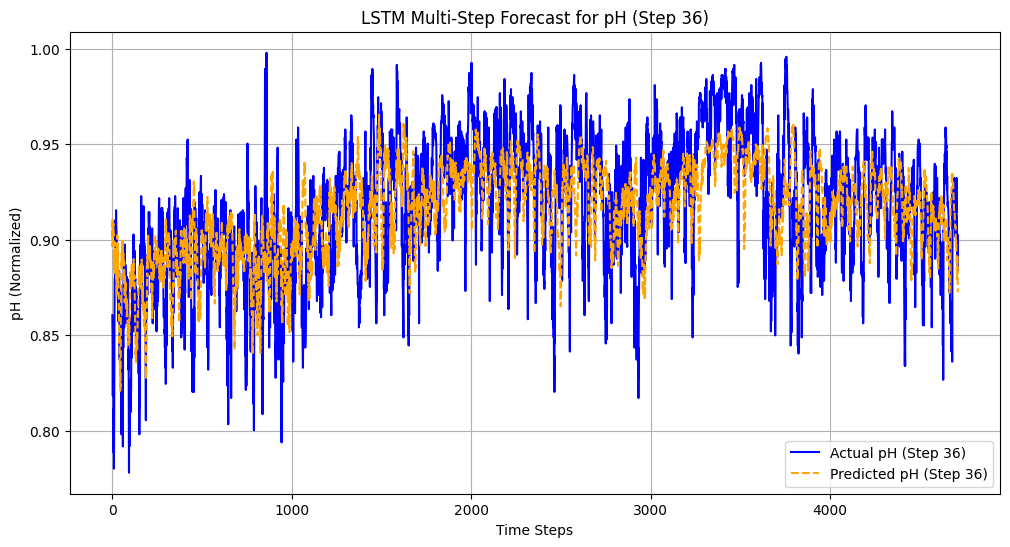

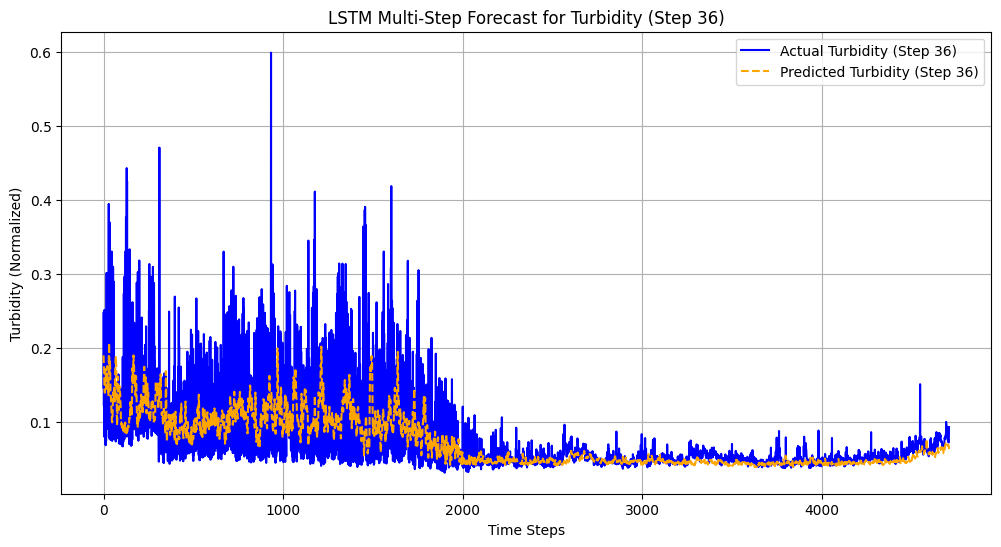

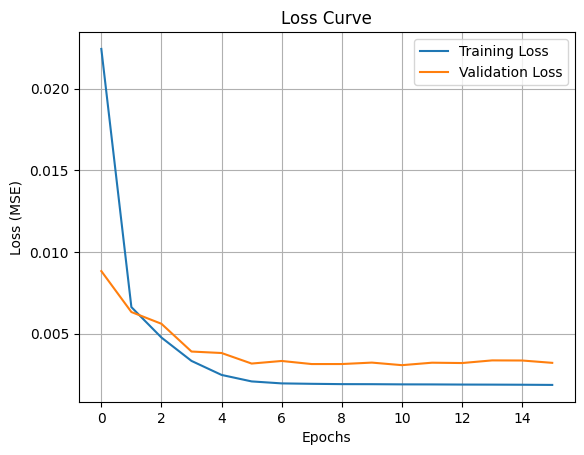

Dissolved Oxygen - MSE: 0.0098, MAE: 0.0754, R²: -0.4122
Temperature - MSE: 0.0042, MAE: 0.0549, R²: 0.5826
Salinity - MSE: 0.0042, MAE: 0.0607, R²: -22.1014
pH - MSE: 0.0011, MAE: 0.0261, R²: 0.1822
Turbidity - MSE: 0.0024, MAE: 0.0279, R²: 0.2869


In [14]:
# --- Libraries ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Data Preprocessing ---
# Load dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'
data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Step 1: Handle Irregular Time Steps
data.set_index('Timestamp', inplace=True)
data = data.resample('10T').mean()  # Resample to 10-minute intervals
data.interpolate(method='time', inplace=True)

# Step 2: Remove Duplicate Timestamps
data = data.reset_index()
data = data.drop_duplicates(subset='Timestamp')

# Step 3: Select Relevant Features
target_columns = ['Dissolved Oxygen', 'Temperature', 'Salinity', 'pH', 'Turbidity']
data = data[['Timestamp'] + target_columns]

# Step 4: Add Moving Averages for Target Variables
for target in target_columns:
    data[f'{target}_MA3'] = data[target].rolling(window=3).mean()
    data[f'{target}_MA5'] = data[target].rolling(window=5).mean()
data.fillna(method='bfill', inplace=True)  # Fill missing values introduced by moving averages

# Step 5: Add Lagged Features for Targets
for target in target_columns:
    for lag in range(1, 4):  # Adding 3 lagged features for each target
        data[f'{target}_lag{lag}'] = data[target].shift(lag)
data.dropna(inplace=True)  # Drop rows with NaN values introduced by lagging

# Step 6: Normalize Features
scaler = MinMaxScaler()
scaled_columns = target_columns + [f'{target}_lag{lag}' for target in target_columns for lag in range(1, 4)] + \
                 [f'{target}_MA3' for target in target_columns] + [f'{target}_MA5' for target in target_columns]
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Step 7: Prepare Features and Multi-Step Multi-Variable Target
horizon = 36  # Forecast horizon (6 hours)
X = data.drop(columns=['Timestamp'] + target_columns).values
y = np.array([data[target_columns].iloc[i:i + horizon].values for i in range(len(data) - horizon)])

# Trim X to match y
X = X[:len(y)]

# Step 8: Split Data into Training, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Reshape X for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- LSTM Model Definition ---
def build_lstm_model(input_shape, horizon, num_targets):
    model = Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape, name="lstm_1"),
        layers.Dropout(0.3, name="dropout_1"),
        layers.LSTM(64, return_sequences=False, name="lstm_2"),
        layers.Dropout(0.3, name="dropout_2"),
        layers.Dense(horizon * num_targets, activation="linear", name="output_layer"),  # Predict multiple timesteps and targets
        layers.Reshape((horizon, num_targets), name="reshape_output")  # Reshape to [horizon, num_targets]
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", "mse"])
    return model

# Build and compile the LSTM model
num_targets = len(target_columns)
input_shape = (X_train.shape[1], X_train.shape[2])  # [timesteps, features]
model = build_lstm_model(input_shape, horizon, num_targets)

# Print model summary
model.summary()

# --- Model Training ---
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# --- Model Evaluation ---
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}, Test MSE: {test_mse}, Test MAE: {test_mae}")

# --- Predictions ---
predictions = model.predict(X_test)

# --- Visualization ---
for i, target in enumerate(target_columns):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test[:, -1, i], label=f'Actual {target} (Step 36)', color='blue')
    plt.plot(range(len(predictions)), predictions[:, -1, i], label=f'Predicted {target} (Step 36)', color='orange', linestyle='--')
    plt.legend()
    plt.title(f'LSTM Multi-Step Forecast for {target} (Step 36)')
    plt.xlabel('Time Steps')
    plt.ylabel(f'{target} (Normalized)')
    plt.grid()
    plt.show()

# --- Training and Validation Loss Curve ---
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# --- Accuracy Metrics ---
metrics = {}
for i, target in enumerate(target_columns):
    mse = mean_squared_error(y_test[:, -1, i], predictions[:, -1, i])  # Compare step 36
    mae = mean_absolute_error(y_test[:, -1, i], predictions[:, -1, i])
    r2 = r2_score(y_test[:, -1, i], predictions[:, -1, i])
    metrics[target] = {"MSE": mse, "MAE": mae, "R²": r2}

# Print metrics for all targets
for target, metric in metrics.items():
    print(f"{target} - MSE: {metric['MSE']:.4f}, MAE: {metric['MAE']:.4f}, R²: {metric['R²']:.4f}")


TCN Model

/tmp/ipykernel_20117/1102113965.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_20117/1102113965.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Training data shape: (24684, 1, 33)
Validation data shape: (3085, 1, 33)
Test data shape: (3086, 1, 33)
Epoch 1/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.2368 - mae: 0.2368 - mse: 0.1303 - val_loss: 0.1458 - val_mae: 0.1458 - val_mse: 0.0430
Epoch 2/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0901 - mae: 0.0901 - mse: 0.0158 - val_loss: 0.1474 - val_mae: 0.1474 - val_mse: 0.0429
Epoch 3/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0806 - mae: 0.0806 - mse: 0.0133 - val_loss: 0.1476 - val_mae: 0.1476 - val_mse: 0.0411
Epoch 4/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0759 - mae: 0.0759 - mse: 0.0121 - val_loss: 0.1284 - val_mae: 0.1284 - val_mse: 0.0329
Epoch 5/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0735 - mae: 0.0735 - mse: 0.0114 - val_loss: 0.1458 - val_mae: 0.1458 - val_mse: 0.0393
Epoch 6/50
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0723 - mae: 0.0723 - mse: 0.0112 - val_loss: 0.1242 - val_ma

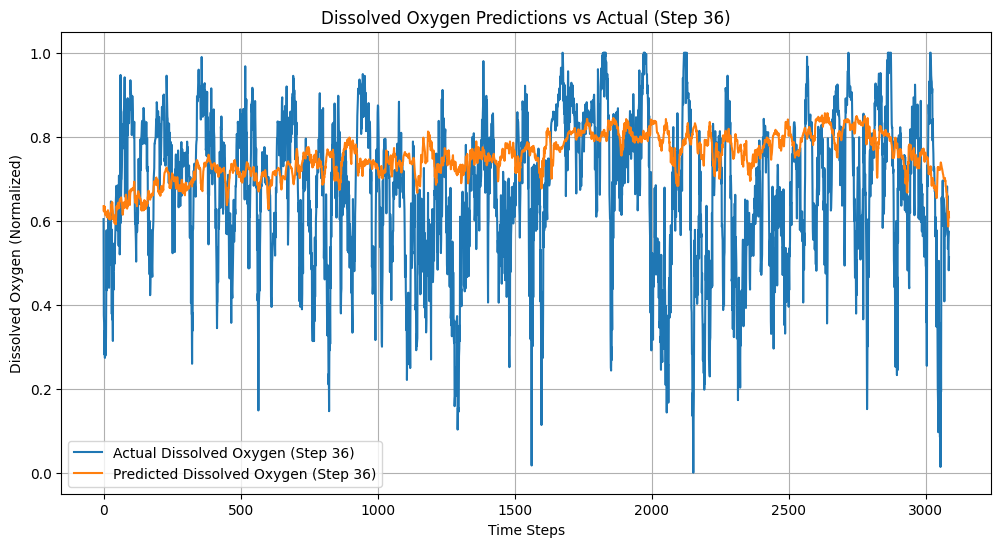

Dissolved Oxygen - MSE: 0.0284, MAE: 0.1345, R²: 0.1133


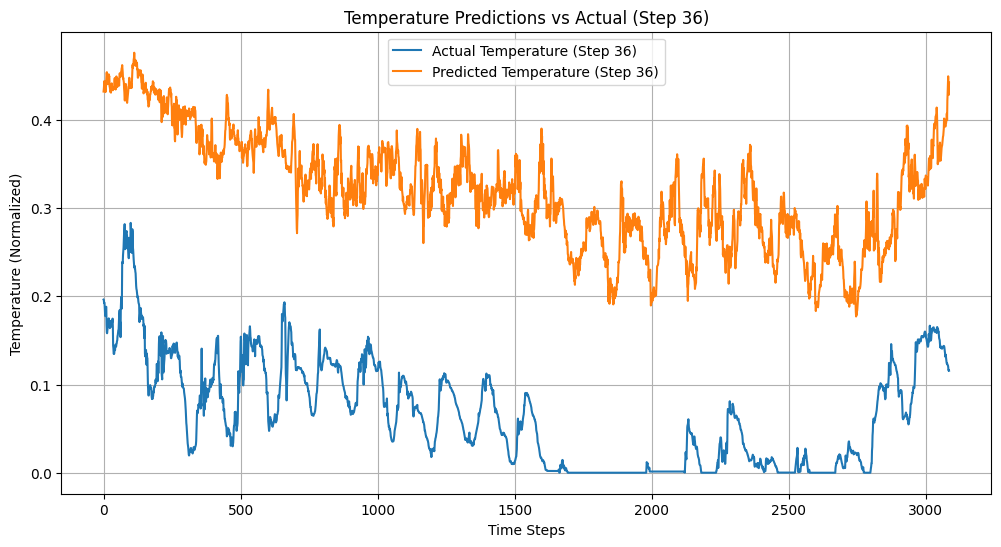

Temperature - MSE: 0.0562, MAE: 0.2322, R²: -14.0750


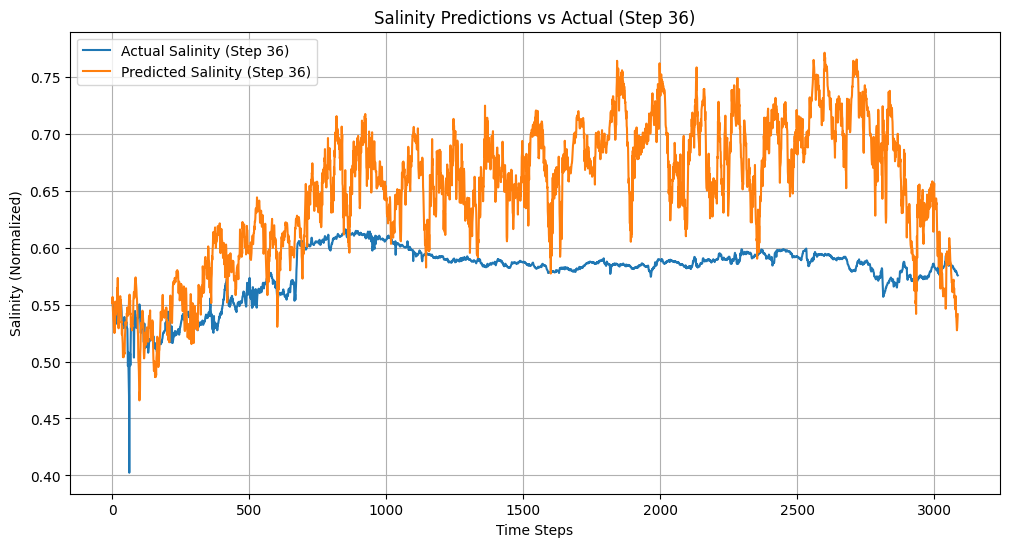

Salinity - MSE: 0.0083, MAE: 0.0799, R²: -14.5884


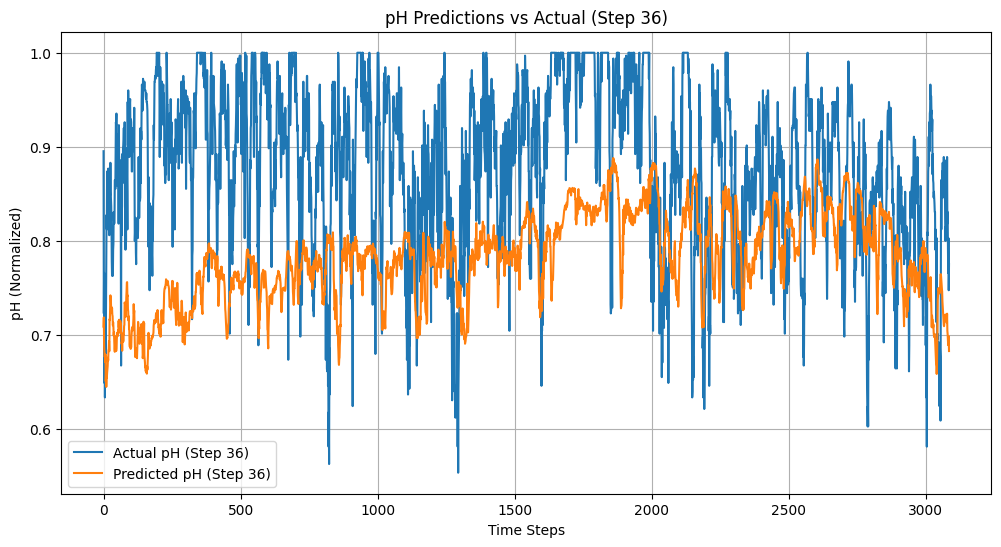

pH - MSE: 0.0225, MAE: 0.1309, R²: -1.9569


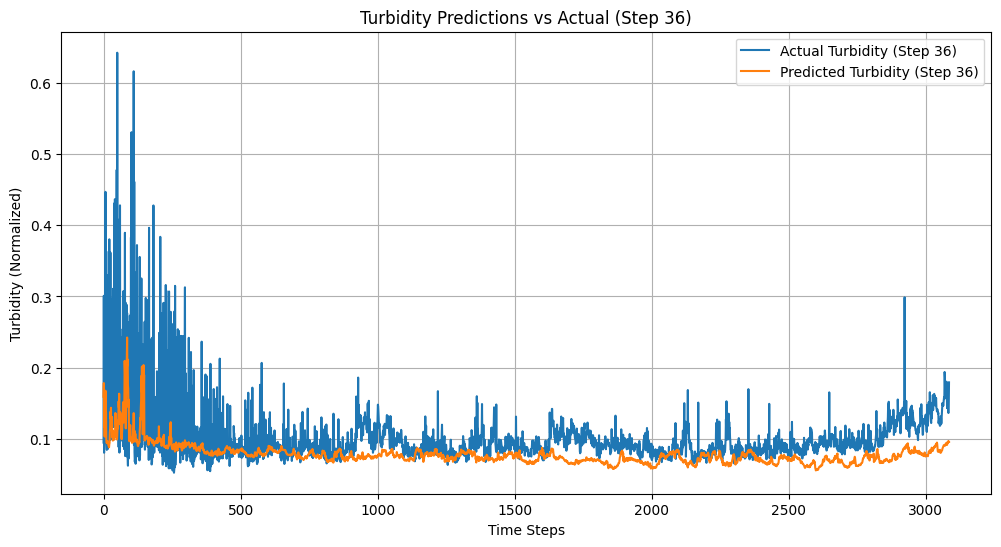

Turbidity - MSE: 0.0022, MAE: 0.0253, R²: 0.0208


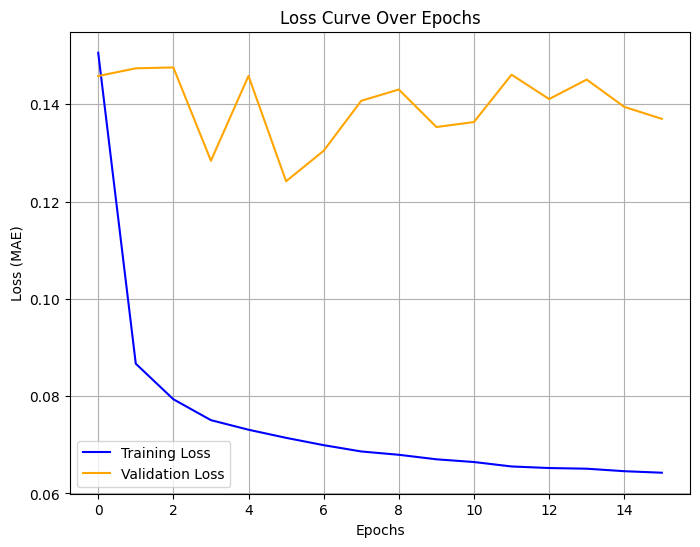

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Data Preprocessing ---
# Load the dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'  # Replace with your file path
data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Step 1: Handle Missing Values
data.fillna(method='ffill', inplace=True)
data.interpolate(method='linear', inplace=True)

# Step 2: Select Relevant Features
target_columns = ['Dissolved Oxygen', 'Temperature', 'Salinity', 'pH', 'Turbidity']
predictors = target_columns + ['Chlorophyll']  # Add Chlorophyll as a predictor
data = data[['Timestamp'] + predictors]

# Step 3: Analyze and Remove Outliers for Targets
for target in target_columns:
    lower_bound = data[target].quantile(0.01)
    upper_bound = data[target].quantile(0.99)
    data[target] = data[target].clip(lower=lower_bound, upper=upper_bound)

# Step 4: Add Moving Averages for Predictors
for feature in predictors:
    data[f'{feature}_MA3'] = data[feature].rolling(window=3).mean()
    data[f'{feature}_MA5'] = data[feature].rolling(window=5).mean()

# Fill NaN values introduced by moving averages
data.fillna(method='bfill', inplace=True)

# Step 5: Add Time-Based Features
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek

# Step 6: Add Lagged Features for Predictors
for feature in predictors:
    for lag in range(1, 4):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Step 7: Normalize Features
scaler = MinMaxScaler()
scaled_columns = predictors + [f'{feature}_lag{lag}' for feature in predictors for lag in range(1, 4)] + \
                 [f'{feature}_MA3' for feature in predictors] + [f'{feature}_MA5' for feature in predictors] + target_columns
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Step 8: Split Features and Targets for Multi-Horizon Forecast
X = data.drop(columns=['Timestamp'] + target_columns).values
y = np.array([data[target_columns].iloc[i:i + 36].values for i in range(len(data) - 36)])  # Multi-step, multi-variable targets

# Trim X to match the target shape
X = X[:len(y)]

# Split Data into Training, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Reshape for models that expect sequential input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# --- Model Definition ---
def build_tcn(input_shape, output_steps, num_targets):
    inputs = tf.keras.Input(shape=input_shape)
    
    # TCN Layers with increasing dilation rates
    x = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, padding="causal", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.2)(x)
    
    x = layers.Conv1D(filters=128, kernel_size=5, dilation_rate=2, padding="causal", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.2)(x)
    
    x = layers.Conv1D(filters=256, kernel_size=7, dilation_rate=4, padding="causal", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.2)(x)
    
    # Global Pooling and Fully Connected Layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_steps * num_targets)(x)  # Multi-step, multi-target output
    outputs = layers.Reshape((output_steps, num_targets))(outputs)
    
    model = Model(inputs, outputs)
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae", metrics=["mse", "mae"])
    return model

# --- Training ---
input_shape = (X_train.shape[1], X_train.shape[2])
num_targets = len(target_columns)
tcn_model = build_tcn(input_shape, output_steps=36, num_targets=num_targets)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = tcn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# --- Evaluation ---
test_loss, test_mse, test_mae = tcn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MAE): {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

# --- Predictions ---
predictions = tcn_model.predict(X_test)

# --- Visualization and Metrics ---
for i, target in enumerate(target_columns):

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, 35, i], label=f"Actual {target} (Step 36)")
    plt.plot(predictions[:, 35, i], label=f"Predicted {target} (Step 36)")
    plt.legend()
    plt.title(f"{target} Predictions vs Actual (Step 36)")
    plt.xlabel("Time Steps")
    plt.ylabel(f"{target} (Normalized)")
    plt.grid()
    plt.show()

    # Accuracy Metrics
    mse = mean_squared_error(y_test[:, :, i].flatten(), predictions[:, :, i].flatten())
    mae = mean_absolute_error(y_test[:, :, i].flatten(), predictions[:, :, i].flatten())
    r2 = r2_score(y_test[:, :, i].flatten(), predictions[:, :, i].flatten())
    print(f"{target} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# --- Plot Loss over Epochs ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.show()


ARIMA Model


Forecasting Chlorophyll with horizon 10...


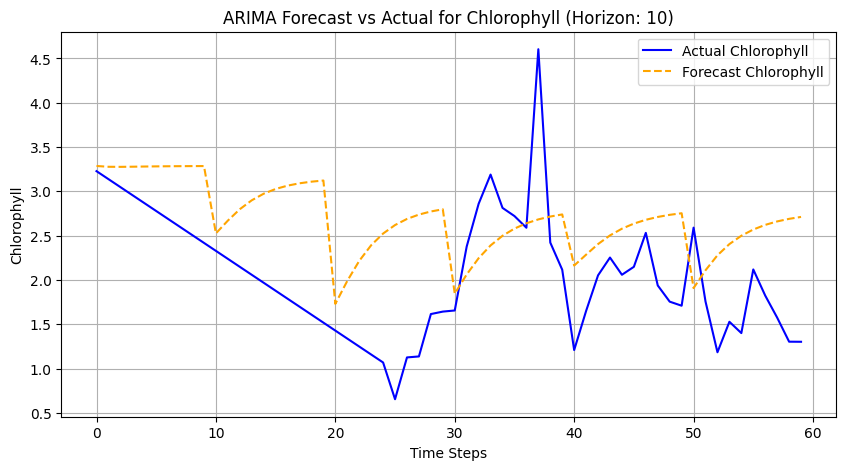

Chlorophyll - RMSE: 0.9244, MAE: 0.7886

Forecasting Temperature with horizon 10...


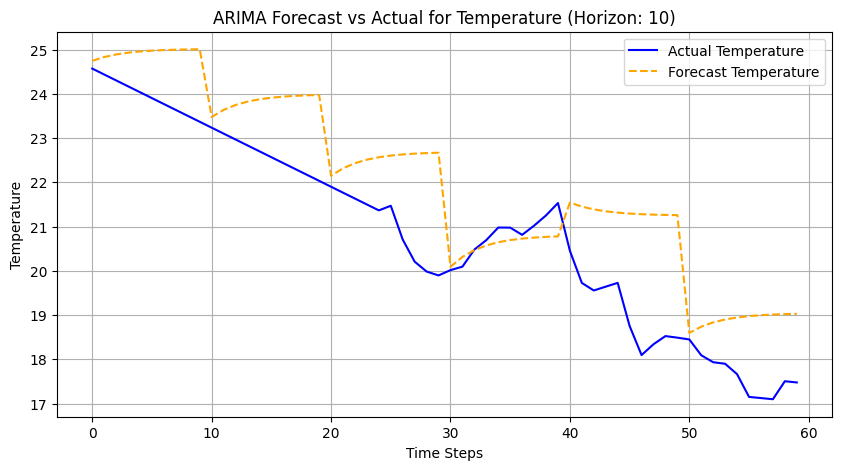

Temperature - RMSE: 1.4798, MAE: 1.2295

Forecasting Dissolved Oxygen with horizon 10...


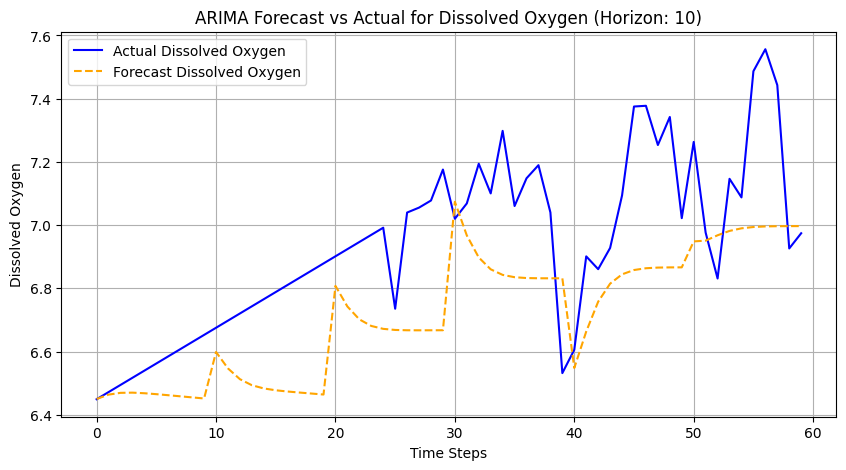

Dissolved Oxygen - RMSE: 0.2824, MAE: 0.2375

Forecasting Metrics:
Chlorophyll - RMSE: 0.9244, MAE: 0.7886
Temperature - RMSE: 1.4798, MAE: 1.2295
Dissolved Oxygen - RMSE: 0.2824, MAE: 0.2375


In [7]:
import pandas as pd
import numpy as np
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---
# Load dataset
file_path = '/home/duncan/Documents/test/brisbane_water_quality.csv'  # Replace with your file path
data = pd.read_csv(file_path, parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Selecting relevant features
data = data[['Chlorophyll', 'Temperature', 'Dissolved Oxygen']]
data = data.resample('D').mean()  # Resample to daily frequency
data.interpolate(method='linear', inplace=True)  # Handle missing values

# Split data into training and testing sets
split = int(len(data) * 0.8)
train_data = data.iloc[:split]
test_data = data.iloc[split:]

# --- ARIMA Forecasting with Adjustable Horizon ---
def forecast_arima_with_horizon(train, test, variable_name, forecast_horizon):
    """
    Improved ARIMA forecasting with incremental training and aligned plots.
    """
    # Prepare the data for StatsForecast
    train_df = train[[variable_name]].reset_index()
    train_df.columns = ['ds', 'y']
    train_df['unique_id'] = 'series'

    # Initialize the StatsForecast model with AutoARIMA
    model = StatsForecast(models=[AutoARIMA()], freq='D', n_jobs=1)

    # Initialize variables for incremental training and predictions
    model.fit(train_df)
    predictions = []
    actuals = []

    for i in range(0, len(test) - forecast_horizon, forecast_horizon):
        # Extract the forecast window
        actual_values = test[variable_name].iloc[i:i + forecast_horizon].values
        forecast = model.predict(forecast_horizon)['AutoARIMA'].values

        # Append results for evaluation
        predictions.extend(forecast)
        actuals.extend(actual_values)

        # Update training data with the actual values
        new_train_data = pd.DataFrame({
            'ds': test.index[i:i + forecast_horizon],
            'y': actual_values,
            'unique_id': ['series'] * forecast_horizon
        })
        train_df = pd.concat([train_df, new_train_data], ignore_index=True)
        model.fit(train_df)

    # Evaluate forecast performance
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(actuals)), actuals, label=f'Actual {variable_name}', color='blue')
    plt.plot(range(len(predictions)), predictions, label=f'Forecast {variable_name}', color='orange', linestyle='--')
    plt.title(f'ARIMA Forecast vs Actual for {variable_name} (Horizon: {forecast_horizon})')
    plt.xlabel('Time Steps')
    plt.ylabel(variable_name)
    plt.legend()
    plt.grid()
    plt.show()

    return predictions, rmse, mae


# Forecast horizon (adjustable)
forecast_horizon = int(input("Enter the forecast horizon (e.g., 1, 5, 10): "))

# Forecast and evaluate for each variable
results = {}
for variable in data.columns:
    print(f"\nForecasting {variable} with horizon {forecast_horizon}...")
    predictions, rmse, mae = forecast_arima_with_horizon(train_data, test_data, variable, forecast_horizon)
    results[variable] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}
    print(f"{variable} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# --- Print Overall Metrics ---
print("\nForecasting Metrics:")
for variable, metrics in results.items():
    print(f"{variable} - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")
